一、问题：计算一个“怪异”固体的体积

想象一下，在三维空间中有一个物体，它不是一个标准的球体、立方体或圆锥体，而是由以下三个不等式同时定义的区域：
x² + y² + z² ≤ 1 (它必须在一个半径为 1 的球体内部)
z > sin(5x) * cos(5y) (它的“底部”是一个起伏非常剧烈的波浪形曲面)
x + y + z > 0.5 (它被一个倾斜的平面从一侧切掉了一部分)
为什么这个问题极其复杂？
要用传统微积分（三重积分）来计算这个体积，你需要：
确定积分的边界：这是一个巨大的挑战。由于sin和cos函数的周期性以及平面的切割，积分区域会被分割成许多不规则的小块，为每一小块精确地写出 x, y, z 的积分上下限几乎是不可能的任务。
执行积分：即使你能写出积分表达式，被积函数也会非常复杂，很可能没有解析解。
这是一个典型的“理论上可积，但实际上无法下手”的问题。
蒙特卡洛方法的“奇效”再次登场：
它完全无视这些复杂的边界和曲面。它的逻辑依然简单粗暴：在一个更大的、规则的“盒子”里随机撒点，然后数一数有多少点落在了我们想要计算的那个“怪异”物体内部。

二、蒙特卡洛的“3D撒豆子”思想

这个过程和计算π的“投飞镖”游戏几乎一模一样，只是从二维升级到了三维：
定义一个“盒子” (Bounding Box)：我们知道这个怪异物体完全包含在半径为1的球体内。因此，我们可以定义一个边长为 2 的立方体（从-1到1），将整个球体包裹起来。这个立方体就是我们的“靶子”。
游戏规则：在这个边长为 2 的立方体内，随机地生成大量的点。
判断与计数：对于每一个生成的随机点 (x, y, z)，我们检查它是否同时满足上面定义物体的三个不等式条件。如果满足，就给计数器加一。
现在，我们来分析：
立方体的体积：Volume_box = 2 * 2 * 2 = 8
怪异固体的体积：Volume_solid (这是我们要求的)
根据大数定律，当随机点的数量足够多时：
(落在物体内的点的数量) / (生成的总点数) ≈ Volume_solid / Volume_box
通过移项，我们得到了估算体积的公式：
Volume_solid ≈ Volume_box * (落在物体内的点的数量) / (生成的总点数)
问题的复杂度从求解恐怖的三重积分，瞬间降低到了做三次简单的逻辑判断和一次计数！

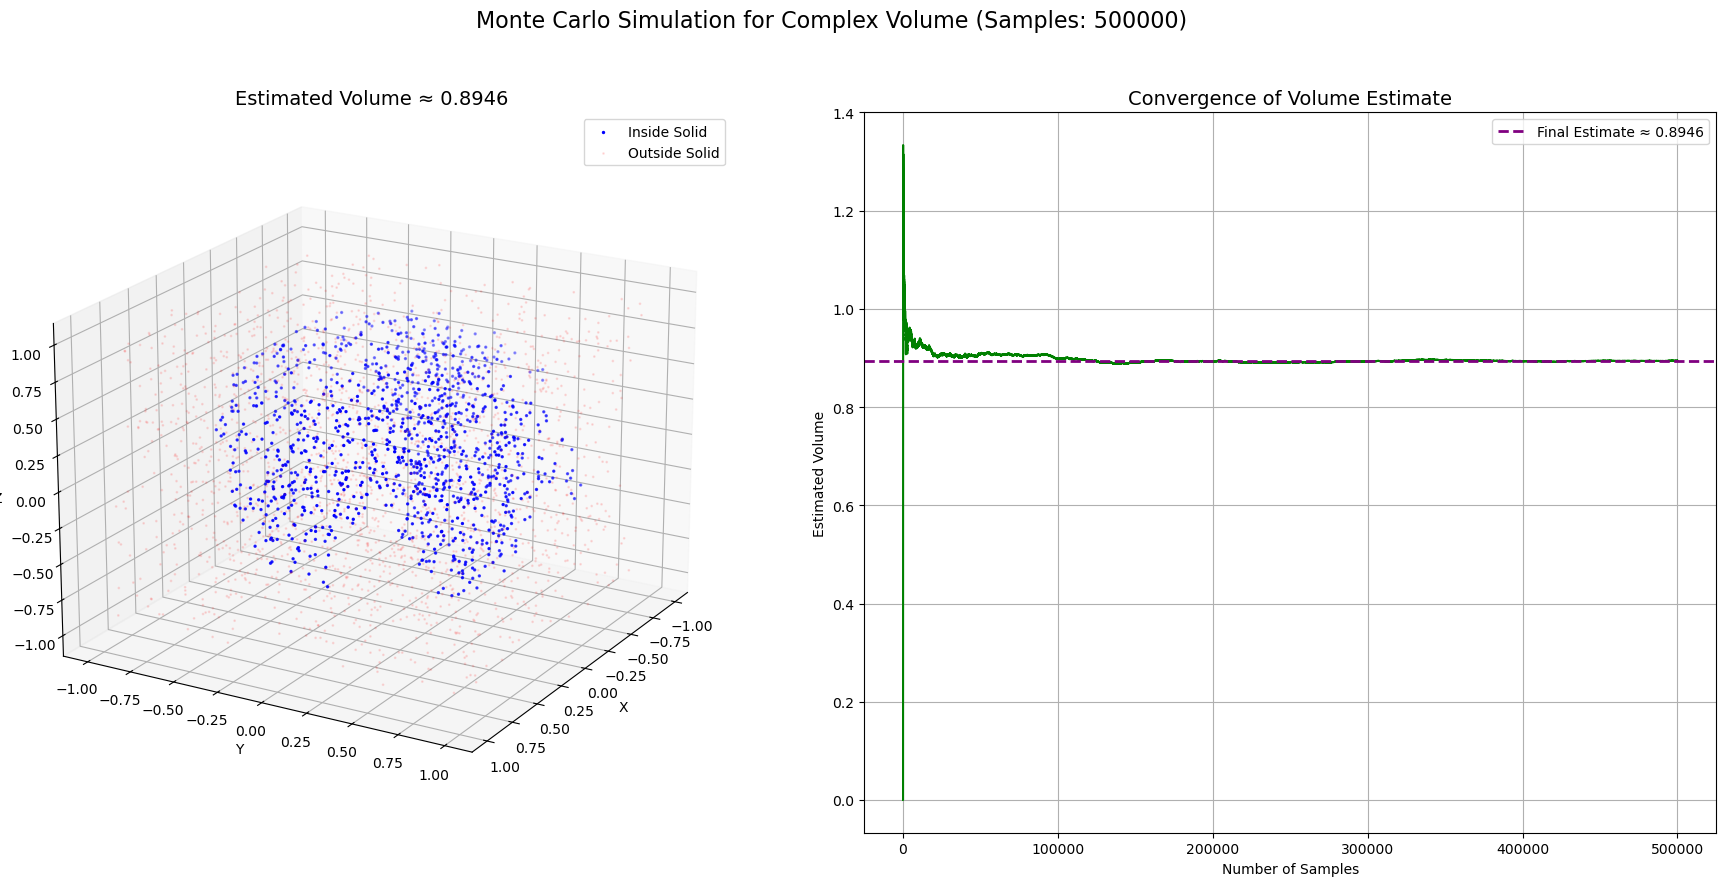

生成的总点数: 500000
落在物体内部的点数: 55914
物体的最终估算体积: 0.894624


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. 模拟参数 ---
NUM_SAMPLES = 500000  # 生成的总点数，需要足够多才能精确
BOUNDING_BOX_VOLUME = 8.0  # 立方体体积 (2x2x2)

# --- 2. "3D撒豆子"模拟 ---
# 在 [-1, 1] x [-1, 1] x [-1, 1] 的立方体内随机生成点
# points 是一个 (NUM_SAMPLES, 3) 的数组
points = np.random.uniform(-1, 1, (NUM_SAMPLES, 3))
x, y, z = points[:, 0], points[:, 1], points[:, 2]

# --- 3. 检查每个点是否在"怪异"固体内部 ---
# 条件1: 在球体内
cond1 = x**2 + y**2 + z**2 <= 1
# 条件2: 在波浪曲面上方
cond2 = z > np.sin(5 * x) * np.cos(5 * y)
# 条件3: 在倾斜平面的一侧
cond3 = x + y + z > 0.5

# 只有同时满足三个条件的点才算在内部
is_inside = cond1 & cond2 & cond3

# 统计落在内部的点的数量
num_inside = np.sum(is_inside)

# --- 4. 计算体积的估算值 ---
volume_estimate = BOUNDING_BOX_VOLUME * num_inside / NUM_SAMPLES

# --- 5. 可视化 ---
fig = plt.figure(figsize=(18, 9))
fig.suptitle(f'Monte Carlo Simulation for Complex Volume (Samples: {NUM_SAMPLES})', fontsize=16)

# --- 子图1: 3D可视化固体形状 ---
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_title(f'Estimated Volume ≈ {volume_estimate:.4f}', fontsize=14)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# 为了性能和清晰度，只显示部分点
display_samples = min(NUM_SAMPLES, 10000)
points_disp = points[:display_samples]
is_inside_disp = is_inside[:display_samples]

# 绘制落在内部的点，这些点共同构成了我们固体的形状
ax1.scatter(points_disp[is_inside_disp, 0], 
            points_disp[is_inside_disp, 1], 
            points_disp[is_inside_disp, 2], 
            color='blue', s=2, label='Inside Solid')

# 绘制一小部分外部的点作为参考背景
num_outside_to_display = int(display_samples * 0.2)
outside_points = points_disp[~is_inside_disp]
if len(outside_points) > num_outside_to_display:
    display_outside_indices = np.random.choice(len(outside_points), num_outside_to_display, replace=False)
    outside_points = outside_points[display_outside_indices]

ax1.scatter(outside_points[:, 0], 
            outside_points[:, 1], 
            outside_points[:, 2], 
            color='red', s=1, alpha=0.1, label='Outside Solid')

ax1.legend()
ax1.view_init(elev=20, azim=30) # 调整视角

# --- 子图2: 体积估算值的收敛过程 ---
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('Convergence of Volume Estimate', fontsize=14)
ax2.set_xlabel('Number of Samples')
ax2.set_ylabel('Estimated Volume')
ax2.grid(True)

# 计算历史估算值
cumulative_inside = np.cumsum(is_inside)
sample_counts = np.arange(1, NUM_SAMPLES + 1)
volume_estimates_history = BOUNDING_BOX_VOLUME * cumulative_inside / sample_counts

ax2.plot(sample_counts, volume_estimates_history, color='green', lw=1.5)
ax2.axhline(y=volume_estimate, color='purple', linestyle='--', lw=2, label=f'Final Estimate ≈ {volume_estimate:.4f}')
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print(f"生成的总点数: {NUM_SAMPLES}")
print(f"落在物体内部的点数: {num_inside}")
print(f"物体的最终估算体积: {volume_estimate}")